# Installation + Importation


In [161]:
#!pip install yahoofinancials

In [162]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
from sklearn.metrics import r2_score
import itertools
import seaborn as sns
import matplotlib.dates as mdates
from scipy.stats import zscore
from sklearn.cluster import KMeans

# Data Download

In [163]:
amzn = yf.download('AMZN', start='2015-01-01', end='2025-01-01', progress=False)
amzn.to_csv('AMZN.csv')

tip = yf.download('TIP', start='2015-01-01', end='2025-01-01', progress=False)
tip.to_csv('TIP.csv')

amzn = pd.read_csv('AMZN.csv', skiprows=2)
tip = pd.read_csv('TIP.csv', skiprows=2)

if amzn.shape[1] == 7:
    amzn.drop(amzn.columns[1], axis=1, inplace=True)

if tip.shape[1] == 7:
    tip.drop(tip.columns[1], axis=1, inplace=True)


In [164]:

amzn.columns = ['Date', 'Close_amzn', 'High_amzn', 'Low_amzn', 'Open_amzn', 'Volume_amzn']
tip.columns = ['Date', 'Close_tip', 'High_tip', 'Low_tip', 'Open_tip', 'Volume_tip']

#fusion of 2 stocks
merged_df = pd.merge(amzn, tip, on='Date')

# Column Normalization
scaler = MinMaxScaler(feature_range=(0, 1))
features = ['Close_amzn', 'High_amzn', 'Low_amzn', 'Open_amzn', 'Volume_amzn',
            'Close_tip', 'High_tip', 'Low_tip', 'Open_tip','Volume_tip']

merged_df[features] = scaler.fit_transform(merged_df[features])

In [165]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2516 entries, 0 to 2515
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         2516 non-null   object 
 1   Close_amzn   2516 non-null   float64
 2   High_amzn    2516 non-null   float64
 3   Low_amzn     2516 non-null   float64
 4   Open_amzn    2516 non-null   float64
 5   Volume_amzn  2516 non-null   float64
 6   Close_tip    2516 non-null   float64
 7   High_tip     2516 non-null   float64
 8   Low_tip      2516 non-null   float64
 9   Open_tip     2516 non-null   float64
 10  Volume_tip   2516 non-null   float64
dtypes: float64(10), object(1)
memory usage: 216.3+ KB


# Data Exploration

In [166]:
merged_df.describe()

,Close_amzn,High_amzn,Low_amzn,Open_amzn,Volume_amzn,Close_tip,High_tip,Low_tip,Open_tip,Volume_tip
count,2516.000000,2516.000000,2516.000000,2516.000000,2516.000000,2516.000000,2516.000000,2516.000000,2516.000000,2516.000000
mean,0.397496,0.402208,0.401136,0.398683,0.132300,0.438538,0.433135,0.445130,0.438394,0.105012
std,0.247842,0.250935,0.250420,0.248541,0.087899,0.236776,0.234871,0.236630,0.230738,0.106671
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.155775,0.156956,0.158246,0.157145,0.077259,0.268963,0.265523,0.276472,0.273898,0.034768
50%,0.367024,0.370852,0.370484,0.367963,0.108749,0.395442,0.390135,0.402995,0.397119,0.073113
75%,0.638243,0.647104,0.643130,0.639967,0.162472,0.515745,0.512160,0.523163,0.513983,0.137843
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


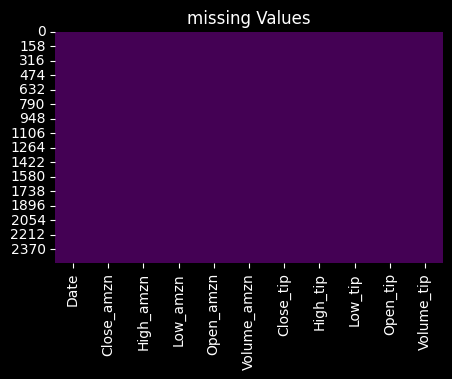

In [167]:
plt.style.use('dark_background')
plt.figure(figsize=(5, 3))
sns.heatmap(merged_df.isnull(), cbar=False, cmap='viridis')
plt.title('missing Values')
plt.show()


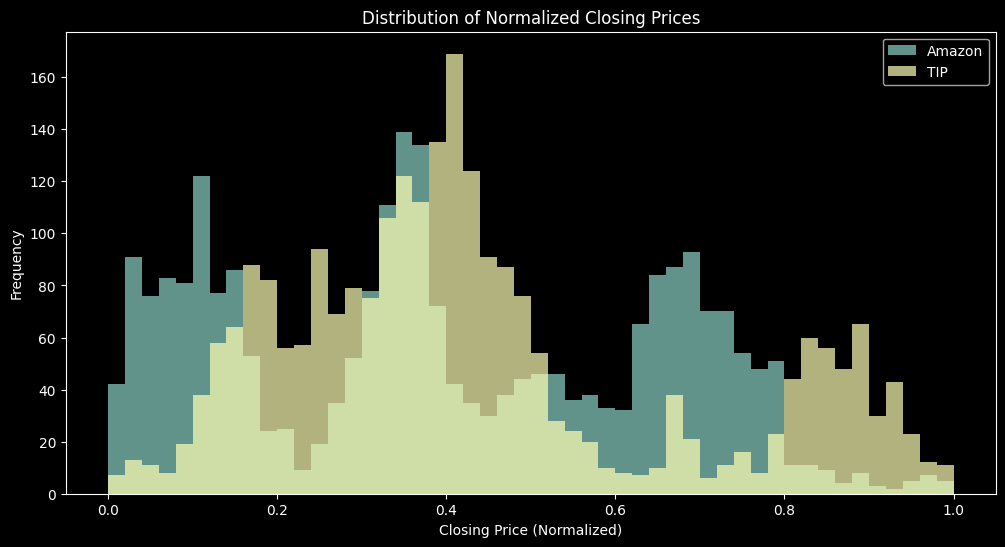

In [168]:
plt.style.use('dark_background')
plt.figure(figsize=(12, 6))
plt.hist(merged_df['Close_amzn'], bins=50, alpha=0.7, label='Amazon')
plt.hist(merged_df['Close_tip'], bins=50, alpha=0.7, label='TIP')
plt.title('Distribution of Normalized Closing Prices')
plt.xlabel('Closing Price (Normalized)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

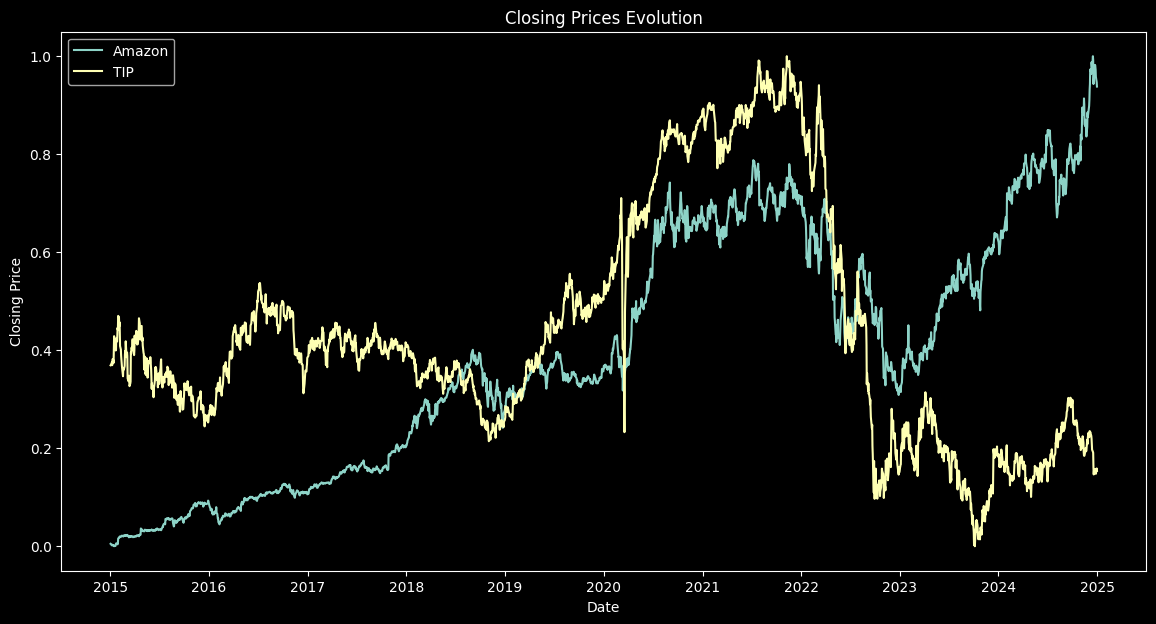

In [169]:
plt.style.use('dark_background')
merged_df['Date'] = pd.to_datetime(merged_df['Date'])
plt.figure(figsize=(14, 7))
plt.plot(merged_df['Date'], merged_df['Close_amzn'], label='Amazon')
plt.plot(merged_df['Date'], merged_df['Close_tip'], label='TIP')
plt.title('Closing Prices Evolution', color='white')
plt.xlabel('Date', color='white')
plt.ylabel('Closing Price', color='white')
plt.legend()
plt.show()



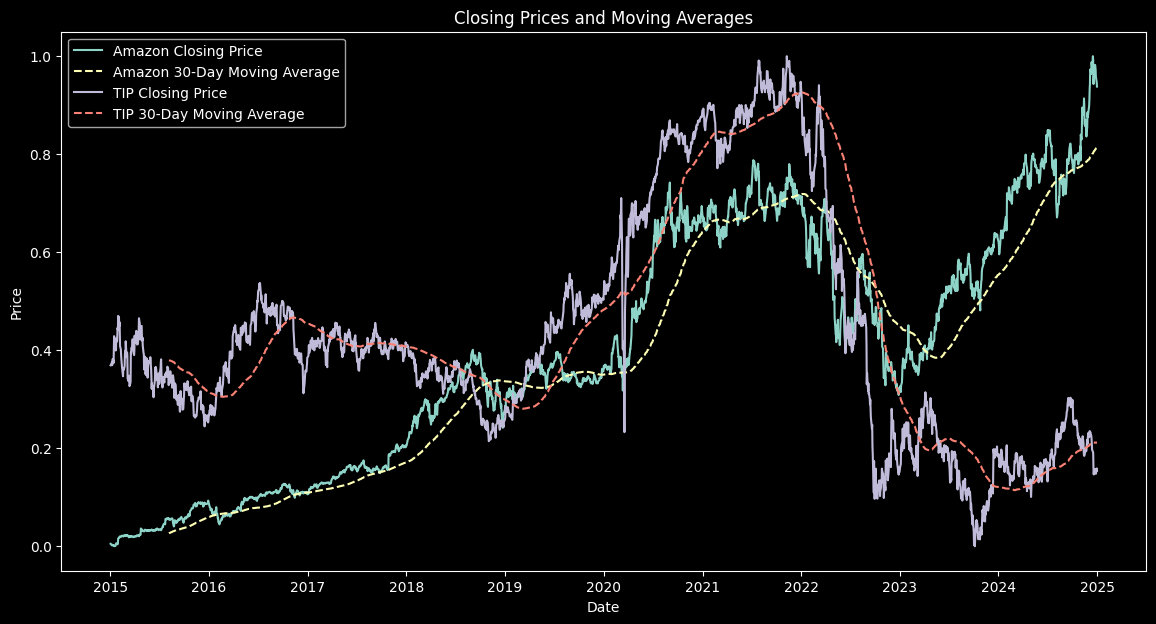

In [170]:
merged_df['AMZN_MA_30'] = merged_df['Close_amzn'].rolling(window=150).mean()
merged_df['TIP_MA_30'] = merged_df['Close_tip'].rolling(window=150).mean()

plt.figure(figsize=(14, 7))
plt.plot(merged_df['Date'], merged_df['Close_amzn'], label='Amazon Closing Price')
plt.plot(merged_df['Date'], merged_df['AMZN_MA_30'], label='Amazon 30-Day Moving Average', linestyle='--')
plt.plot(merged_df['Date'], merged_df['Close_tip'], label='TIP Closing Price')
plt.plot(merged_df['Date'], merged_df['TIP_MA_30'], label='TIP 30-Day Moving Average', linestyle='--')
plt.title('Closing Prices and Moving Averages', color='white')
plt.xlabel('Date', color='white')
plt.ylabel('Price', color='white')
plt.legend()
plt.show()



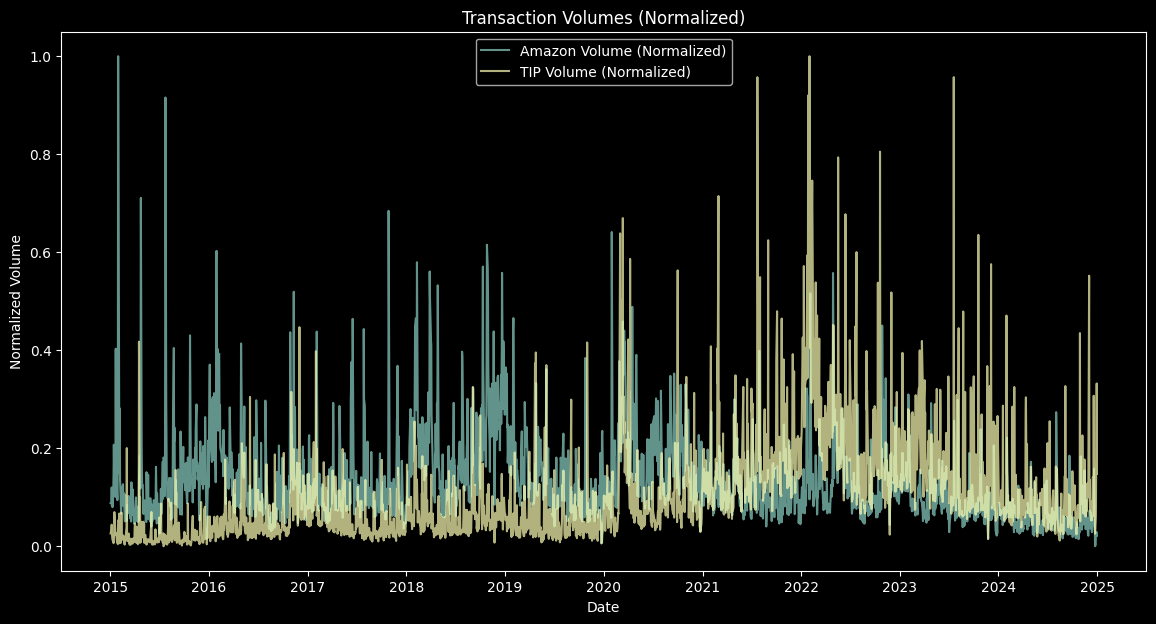

In [171]:
plt.figure(figsize=(14, 7))
plt.plot(merged_df['Date'], merged_df['Volume_amzn'], label='Amazon Volume (Normalized)', alpha=0.7)
plt.plot(merged_df['Date'], merged_df['Volume_tip'], label='TIP Volume (Normalized)', alpha=0.7)
plt.title('Transaction Volumes (Normalized)', color='white')
plt.xlabel('Date', color='white')
plt.ylabel('Normalized Volume', color='white')
plt.legend()
plt.show()

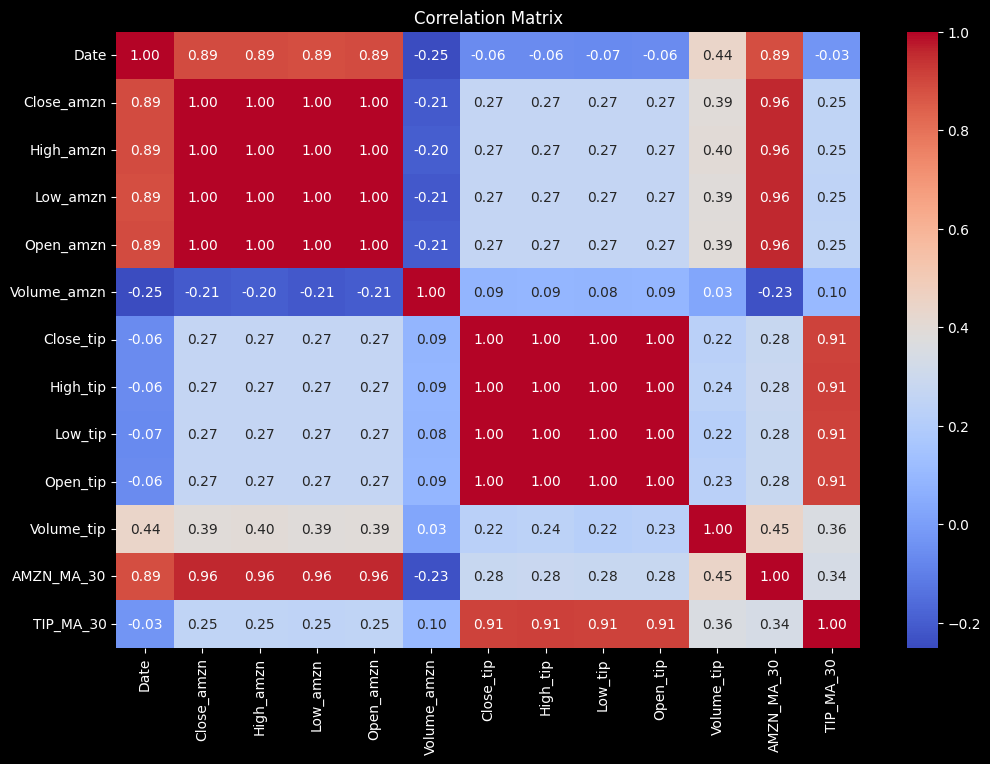

In [172]:
plt.style.use('dark_background')
correlation_matrix = merged_df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title('Correlation Matrix', color='white')
plt.show()

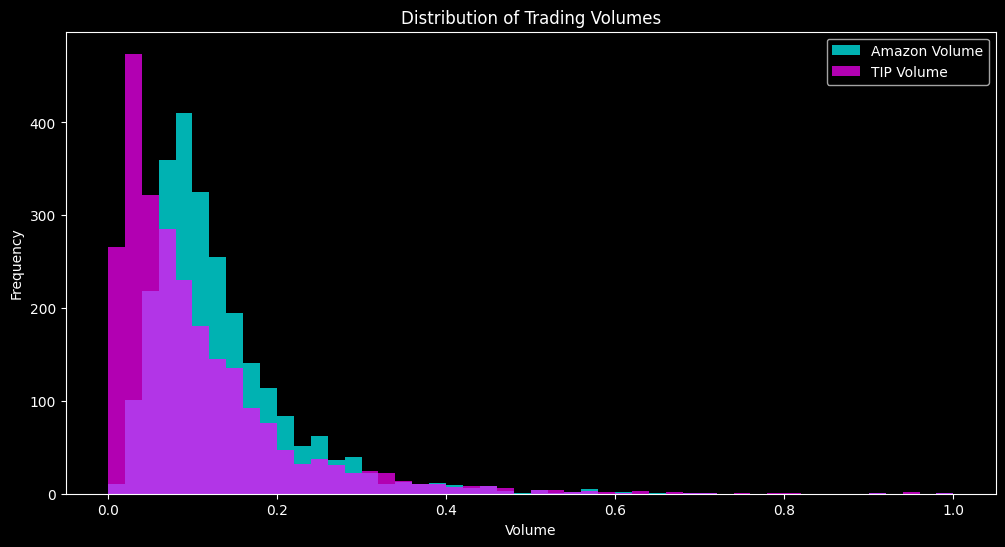

In [173]:
plt.figure(figsize=(12, 6))
plt.hist(merged_df['Volume_amzn'], bins=50, alpha=0.7, label='Amazon Volume', color='cyan')
plt.hist(merged_df['Volume_tip'], bins=50, alpha=0.7, label='TIP Volume', color='magenta')
plt.title('Distribution of Trading Volumes', color='white')
plt.xlabel('Volume', color='white')
plt.ylabel('Frequency', color='white')
plt.legend()
plt.show()


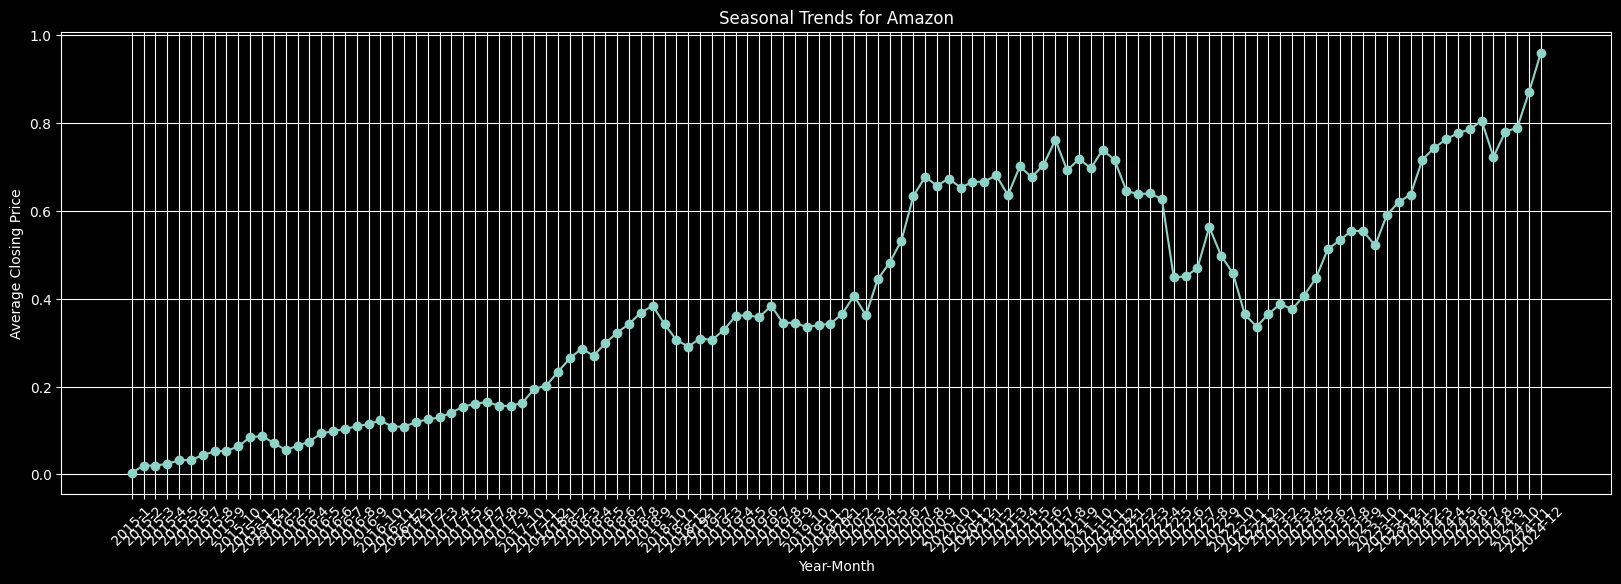

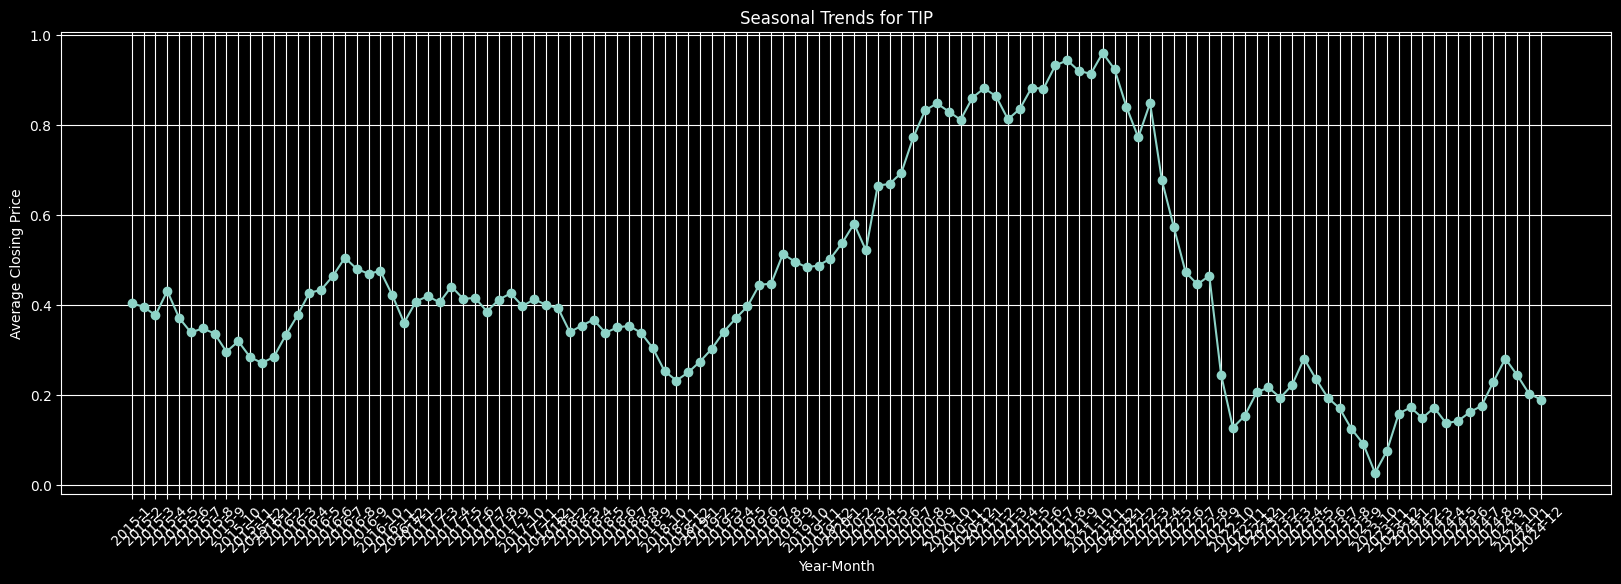

In [174]:
# Seasonal Trends Analysis: Grouping by Year and Month
merged_df['Date'] = pd.to_datetime(merged_df['Date'])
merged_df['Year'] = merged_df['Date'].dt.year
merged_df['Month'] = merged_df['Date'].dt.month

def plot_seasonal_trends(df, stock_column, title):
    grouped = df.groupby(['Year', 'Month'])[stock_column].mean().reset_index()
    grouped['YearMonth'] = grouped['Year'].astype(str) + '-' + grouped['Month'].astype(str)
    plt.style.use('dark_background')
    plt.figure(figsize=(20, 6))
    plt.plot(grouped['YearMonth'], grouped[stock_column], marker='o')
    plt.title(f"{title}")
    plt.xlabel("Year-Month")
    plt.ylabel("Average Closing Price")
    plt.xticks(rotation=45)
    plt.grid()
    plt.show()

plot_seasonal_trends(merged_df, 'Close_amzn', 'Seasonal Trends for Amazon')
plot_seasonal_trends(merged_df, 'Close_tip', 'Seasonal Trends for TIP')

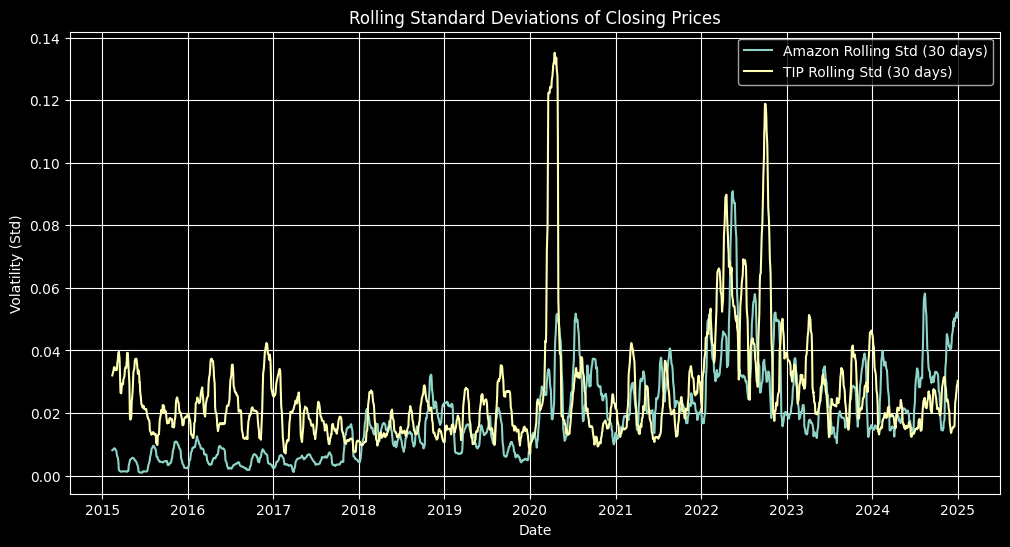

In [175]:
# Volatility Analysis: Rolling Standard Deviations
merged_df['AMZN_Rolling_Std'] = merged_df['Close_amzn'].rolling(window=30).std()
merged_df['TIP_Rolling_Std'] = merged_df['Close_tip'].rolling(window=30).std()
plt.figure(figsize=(12, 6))
plt.plot(merged_df['Date'], merged_df['AMZN_Rolling_Std'], label='Amazon Rolling Std (30 days)')
plt.plot(merged_df['Date'], merged_df['TIP_Rolling_Std'], label='TIP Rolling Std (30 days)')
plt.title('Rolling Standard Deviations of Closing Prices')
plt.xlabel('Date')
plt.ylabel('Volatility (Std)')
plt.legend()
plt.grid()
plt.show()

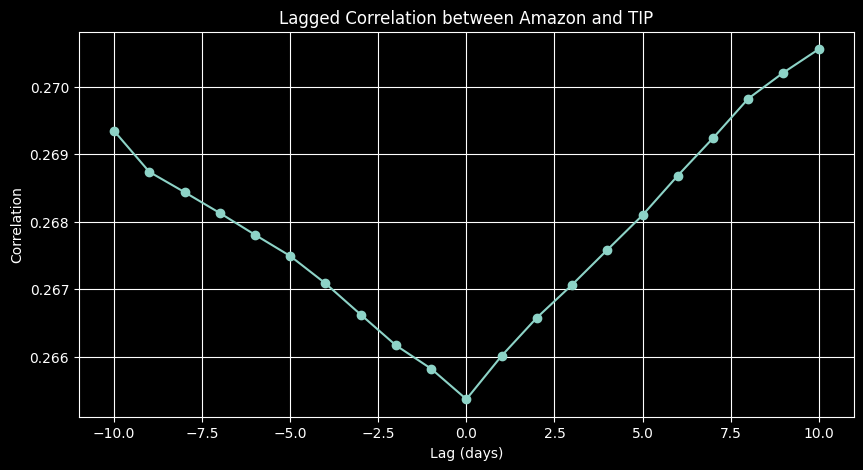

In [176]:
# Lagged Correlation
correlations = []
for lag in range(-10, 11):
    shifted = merged_df['Close_tip'].shift(lag)
    correlation = merged_df['Close_amzn'].corr(shifted)
    correlations.append(correlation)

plt.figure(figsize=(10, 5))
plt.plot(range(-10, 11), correlations, marker='o')
plt.title('Lagged Correlation between Amazon and TIP')
plt.xlabel('Lag (days)')
plt.ylabel('Correlation')
plt.grid()
plt.show()

In [177]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2516 entries, 0 to 2515
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              2516 non-null   datetime64[ns]
 1   Close_amzn        2516 non-null   float64       
 2   High_amzn         2516 non-null   float64       
 3   Low_amzn          2516 non-null   float64       
 4   Open_amzn         2516 non-null   float64       
 5   Volume_amzn       2516 non-null   float64       
 6   Close_tip         2516 non-null   float64       
 7   High_tip          2516 non-null   float64       
 8   Low_tip           2516 non-null   float64       
 9   Open_tip          2516 non-null   float64       
 10  Volume_tip        2516 non-null   float64       
 11  AMZN_MA_30        2367 non-null   float64       
 12  TIP_MA_30         2367 non-null   float64       
 13  Year              2516 non-null   int32         
 14  Month             2516 n

In [178]:
columns_to_drop = ['Year', 'Month', 'AMZN_Rolling_Std', 'TIP_Rolling_Std', 'AMZN_MA_30','TIP_MA_30']
merged_df = merged_df.drop(columns=columns_to_drop, axis=1)

# Model definition

In [179]:
# Function to create time sequences
def pre_processing_data(dataset, time_step=1):
    features, labels = [], []
    for i in range(len(dataset) - time_step - 1):
        # Use all columns as features
        features.append(dataset[i:(i + time_step), :])
        # Use `Close_amzn` as the target
        labels.append(dataset[i + time_step, 0])
    return np.array(features), np.array(labels)

In [180]:
# Convert the DataFrame to a numpy array
data = merged_df[features].values

# Define the sequence length and create the datasets
time_step = 100
training_size = int(len(data) * 0.65)
train_data = data[:training_size]
test_data = data[training_size:]

X_train, y_train = pre_processing_data(train_data, time_step)
X_test, y_test = pre_processing_data(test_data, time_step)

# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create a DataLoader for batching
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)


In [181]:
# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size=10, hidden_size=100, num_layers=3, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Last time step output
        return out

# Initialize the model
input_size = len(features)  # 10 columns: Close_amzn, High_amzn, ..., Volume_tip
model = LSTMModel(input_size=input_size, hidden_size=100, num_layers=3, dropout=0.2)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)
print(model)


LSTMModel(
  (lstm): LSTM(10, 100, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=100, out_features=1, bias=True)
)


## which hyperparameters are better?

### hidden_size = 50

In [182]:
'''
# Define specific hyperparameters for hidden_size = 50
hidden_size = 50
num_layers_list = [2, 3, 4]  # Number of LSTM layers
dropouts = [0.1, 0.3]  # Dropout rates
learning_rates = [0.001, 0.002, 0.005]  # Learning rates
num_epochs = 50  # Fixed number of epochs

# Initialize a list to store results
results = []

# Test all hyperparameter combinations for hidden_size = 50
for num_layers, dropout, lr in itertools.product(num_layers_list, dropouts, learning_rates):
    print(f"Testing: hidden_size={hidden_size}, num_layers={num_layers}, dropout={dropout}, lr={lr}")

    # Define the model with the current hyperparameters
    model = LSTMModel(input_size=len(features), hidden_size=hidden_size, num_layers=num_layers, dropout=dropout)

    # Define the loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Train the model
    losses = []
    train_rmse = []
    test_rmse = []

    for epoch in range(num_epochs):
        running_loss = 0
        for batch_x, batch_y in train_loader:
            outputs = model(batch_x)
            loss = criterion(outputs.squeeze(), batch_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Save average loss
        losses.append(running_loss / len(train_loader))

        # Calculate RMSE for training and testing datasets
        with torch.no_grad():
            y_train_pred = model(X_train_tensor).numpy()
            y_test_pred = model(X_test_tensor).numpy()
        train_rmse.append(math.sqrt(mean_squared_error(y_train, y_train_pred)))
        test_rmse.append(math.sqrt(mean_squared_error(y_test, y_test_pred)))

    # Calculate final R^2 scores
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)

    # Add results to the list
    results.append({
        "hidden_size": hidden_size,
        "num_layers": num_layers,
        "dropout": dropout,
        "learning_rate": lr,
        "final_train_rmse": train_rmse[-1],
        "final_test_rmse": test_rmse[-1],
        "train_r2": r2_train,
        "test_r2": r2_test,
    })

    print(f"Finished: Train RMSE={train_rmse[-1]:.4f}, Test RMSE={test_rmse[-1]:.4f}, Train R^2={r2_train:.4f}, Test R^2={r2_test:.4f}")

# Convert results to DataFrame and save to a CSV file
results_df = pd.DataFrame(results)
results_df.to_csv(f"hyperparameter_results_hidden50.csv", index=False)
print("Results for hidden_size = 50 saved to hyperparameter_results_hidden50.csv")

'''

'\n# Define specific hyperparameters for hidden_size = 50\nhidden_size = 50\nnum_layers_list = [2, 3, 4]  # Number of LSTM layers\ndropouts = [0.1, 0.3]  # Dropout rates\nlearning_rates = [0.001, 0.002, 0.005]  # Learning rates\nnum_epochs = 50  # Fixed number of epochs\n\n# Initialize a list to store results\nresults = []\n\n# Test all hyperparameter combinations for hidden_size = 50\nfor num_layers, dropout, lr in itertools.product(num_layers_list, dropouts, learning_rates):\n    print(f"Testing: hidden_size={hidden_size}, num_layers={num_layers}, dropout={dropout}, lr={lr}")\n\n    # Define the model with the current hyperparameters\n    model = LSTMModel(input_size=len(features), hidden_size=hidden_size, num_layers=num_layers, dropout=dropout)\n\n    # Define the loss function and optimizer\n    criterion = nn.MSELoss()\n    optimizer = torch.optim.Adam(model.parameters(), lr=lr)\n\n    # Train the model\n    losses = []\n    train_rmse = []\n    test_rmse = []\n\n    for epoch in 

### hidden_size = 100

In [184]:
'''hidden_size = 100
num_layers_list = [2, 3, 4]
dropouts = [0.1 , 0.2]
learning_rates = [0.0005 , 0.001, 0.002]
num_epochs = 50

results = []

for num_layers, dropout, lr in itertools.product(num_layers_list, dropouts, learning_rates):
    print(f"Testing: hidden_size={hidden_size}, num_layers={num_layers}, dropout={dropout}, lr={lr}")

    model = LSTMModel(input_size=len(features), hidden_size=hidden_size, num_layers=num_layers, dropout=dropout)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    losses = []
    train_rmse = []
    test_rmse = []

    for epoch in range(num_epochs):
        running_loss = 0
        for batch_x, batch_y in train_loader:
            outputs = model(batch_x)
            loss = criterion(outputs.squeeze(), batch_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        losses.append(running_loss / len(train_loader))

        with torch.no_grad():
            y_train_pred = model(X_train_tensor).numpy()
            y_test_pred = model(X_test_tensor).numpy()
        train_rmse.append(math.sqrt(mean_squared_error(y_train, y_train_pred)))
        test_rmse.append(math.sqrt(mean_squared_error(y_test, y_test_pred)))

    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)

    results.append({
        "hidden_size": hidden_size,
        "num_layers": num_layers,
        "dropout": dropout,
        "learning_rate": lr,
        "final_train_rmse": train_rmse[-1],
        "final_test_rmse": test_rmse[-1],
        "train_r2": r2_train,
        "test_r2": r2_test,
    })

    print(f"Finished: Train RMSE={train_rmse[-1]:.4f}, Test RMSE={test_rmse[-1]:.4f}, Train R^2={r2_train:.4f}, Test R^2={r2_test:.4f}")

results_df = pd.DataFrame(results)
results_df.to_csv(f"hyperparameter_results_hidden100.csv", index=False)
print("Résultats pour hidden_size = 100 sauvegardés dans hyperparameter_results_hidden100.csv")
'''

'hidden_size = 100\nnum_layers_list = [2, 3, 4]\ndropouts = [0.1 , 0.2]\nlearning_rates = [0.0005 , 0.001, 0.002]\nnum_epochs = 50\n\nresults = []\n\nfor num_layers, dropout, lr in itertools.product(num_layers_list, dropouts, learning_rates):\n    print(f"Testing: hidden_size={hidden_size}, num_layers={num_layers}, dropout={dropout}, lr={lr}")\n\n    model = LSTMModel(input_size=len(features), hidden_size=hidden_size, num_layers=num_layers, dropout=dropout)\n\n    criterion = nn.MSELoss()\n    optimizer = torch.optim.Adam(model.parameters(), lr=lr)\n\n    losses = []\n    train_rmse = []\n    test_rmse = []\n\n    for epoch in range(num_epochs):\n        running_loss = 0\n        for batch_x, batch_y in train_loader:\n            outputs = model(batch_x)\n            loss = criterion(outputs.squeeze(), batch_y)\n            optimizer.zero_grad()\n            loss.backward()\n            optimizer.step()\n            running_loss += loss.item()\n\n        losses.append(running_loss / le

### time_steps 30, 60, 100, 150, 200, 365

In [198]:
'''time_steps_list = [30, 60, 100, 150, 200, 365]
results = []

for time_step in time_steps_list:
    X_train, y_train = pre_processing_data(train_data, time_step)
    X_validation, y_validation = pre_processing_data(validation_data, time_step)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    X_validation_tensor = torch.tensor(X_validation, dtype=torch.float32)
    y_validation_tensor = torch.tensor(y_validation, dtype=torch.float32)

    model = LSTMModel(input_size=len(features), hidden_size=100, num_layers=2, dropout=0.2)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.002)

    for epoch in range(50):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs.squeeze(), y_train_tensor)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        y_val_pred = model(X_validation_tensor).squeeze().numpy()

    rmse = np.sqrt(mean_squared_error(y_validation, y_val_pred))
    r2 = r2_score(y_validation, y_val_pred)

    results.append({"time_step": time_step, "RMSE": rmse, "R²": r2})

df_results = pd.DataFrame(results)
print(df_results)'''

'time_steps_list = [30, 60, 90, 150, 200, 365]\nresults = []\n\nfor time_step in time_steps_list:\n    # Transformation des données en séquences\n    X_train, y_train = pre_processing_data(train_data, time_step)\n    X_validation, y_validation = pre_processing_data(validation_data, time_step)\n    \n    # Conversion en tenseurs\n    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)\n    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)\n    X_validation_tensor = torch.tensor(X_validation, dtype=torch.float32)\n    y_validation_tensor = torch.tensor(y_validation, dtype=torch.float32)\n    \n    # Initialisation et entraînement du modèle\n    model = LSTMModel(input_size=len(features), hidden_size=100, num_layers=2, dropout=0.2)\n    criterion = nn.MSELoss()\n    optimizer = torch.optim.Adam(model.parameters(), lr=0.002)\n    \n    for epoch in range(50):  # Réduire le nombre d\'époques pour accélérer les tests\n        model.train()\n        optimizer.zero_grad()\n  

## Final Model

In [185]:
training_size = int(len(data) * 0.7)
validation_size = int(len(data) * 0.15)

train_data = data[:training_size]
validation_data = data[training_size:training_size + validation_size]
test_data = data[training_size + validation_size:]

X_train, y_train = pre_processing_data(train_data, time_step)
X_validation, y_validation = pre_processing_data(validation_data, time_step)
X_test, y_test = pre_processing_data(test_data, time_step)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_validation_tensor = torch.tensor(X_validation, dtype=torch.float32)
y_validation_tensor = torch.tensor(y_validation, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

hidden_size=100, num_layers=2, num_epochs = 100

In [186]:
# Building the final model with optimal hyperparameters
model = LSTMModel(input_size=len(features), hidden_size=100, num_layers=2, dropout=0.2)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)


In [187]:
num_epochs = 100

# list to following the performance
train_losses, validation_losses = [], []
train_rmse, validation_rmse = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    for batch_x, batch_y in train_loader:
        outputs = model(batch_x)
        loss = criterion(outputs.squeeze(), batch_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Record average training loss
    train_losses.append(running_loss / len(train_loader))

    # evaluation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_validation_tensor)
        val_loss = criterion(val_outputs.squeeze(), y_validation_tensor)
        validation_losses.append(val_loss.item())

        # Calculation of errors RMSE
        y_train_pred = model(X_train_tensor).numpy()
        y_val_pred = val_outputs.numpy()
        train_rmse.append(math.sqrt(mean_squared_error(y_train, y_train_pred)))
        validation_rmse.append(math.sqrt(mean_squared_error(y_validation, y_val_pred)))

    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Validation Loss: {validation_losses[-1]:.4f}")


Epoch 1/100, Train Loss: 0.0147, Validation Loss: 0.0027
Epoch 2/100, Train Loss: 0.0007, Validation Loss: 0.0013
Epoch 3/100, Train Loss: 0.0004, Validation Loss: 0.0011
Epoch 4/100, Train Loss: 0.0004, Validation Loss: 0.0009
Epoch 5/100, Train Loss: 0.0004, Validation Loss: 0.0006
Epoch 6/100, Train Loss: 0.0003, Validation Loss: 0.0007
Epoch 7/100, Train Loss: 0.0004, Validation Loss: 0.0006
Epoch 8/100, Train Loss: 0.0003, Validation Loss: 0.0006
Epoch 9/100, Train Loss: 0.0004, Validation Loss: 0.0008
Epoch 10/100, Train Loss: 0.0003, Validation Loss: 0.0005
Epoch 11/100, Train Loss: 0.0003, Validation Loss: 0.0005
Epoch 12/100, Train Loss: 0.0002, Validation Loss: 0.0006
Epoch 13/100, Train Loss: 0.0003, Validation Loss: 0.0005
Epoch 14/100, Train Loss: 0.0002, Validation Loss: 0.0006
Epoch 15/100, Train Loss: 0.0003, Validation Loss: 0.0006
Epoch 16/100, Train Loss: 0.0003, Validation Loss: 0.0007
Epoch 17/100, Train Loss: 0.0002, Validation Loss: 0.0005
Epoch 18/100, Train Los

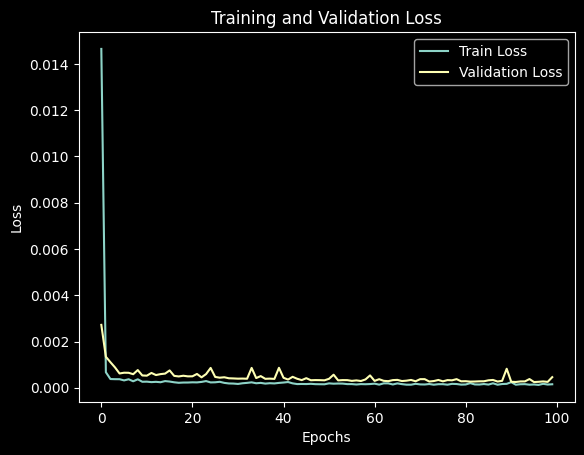

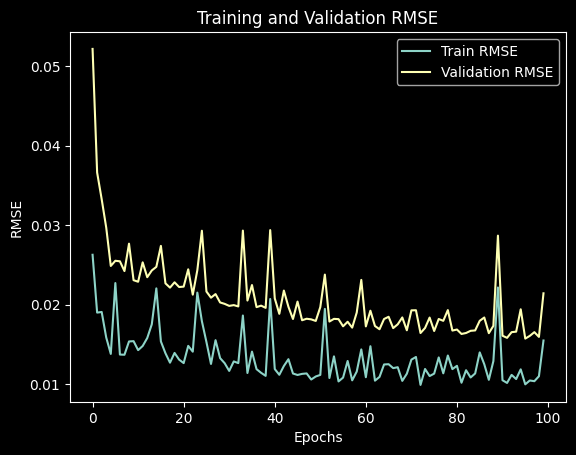

In [188]:
plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

plt.figure()
plt.plot(train_rmse, label='Train RMSE')
plt.plot(validation_rmse, label='Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.title('Training and Validation RMSE')
plt.show()

<ipython-input-189-ed13a3d67964>:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_validation.min(), y_validation.max()], [y_validation.min(), y_validation.max()], 'k--', lw=2, color="red")


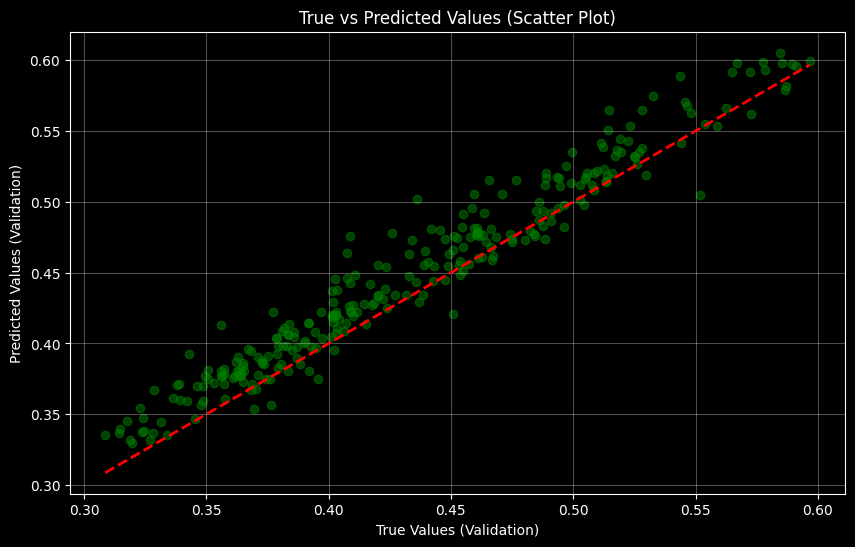

In [189]:
plt.figure(figsize=(10, 6))
plt.scatter(y_validation, y_val_pred, alpha=0.5, color="green")
plt.plot([y_validation.min(), y_validation.max()], [y_validation.min(), y_validation.max()], 'k--', lw=2, color="red")
plt.xlabel("True Values (Validation)")
plt.ylabel("Predicted Values (Validation)")
plt.title("True vs Predicted Values (Scatter Plot)")
plt.grid(alpha=0.3)
plt.show()


## Model Test

In [190]:
model.eval()
with torch.no_grad():

    y_test_pred = model(X_test_tensor).squeeze().numpy()


    test_loss = criterion(torch.tensor(y_test_pred), torch.tensor(y_test)).item()


    test_rmse = math.sqrt(mean_squared_error(y_test, y_test_pred))


    r2_test = r2_score(y_test, y_test_pred)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"R² Score (Test): {r2_test:.4f}")


Test Loss: 0.0025
Test RMSE: 0.0498
R² Score (Test): 0.6861


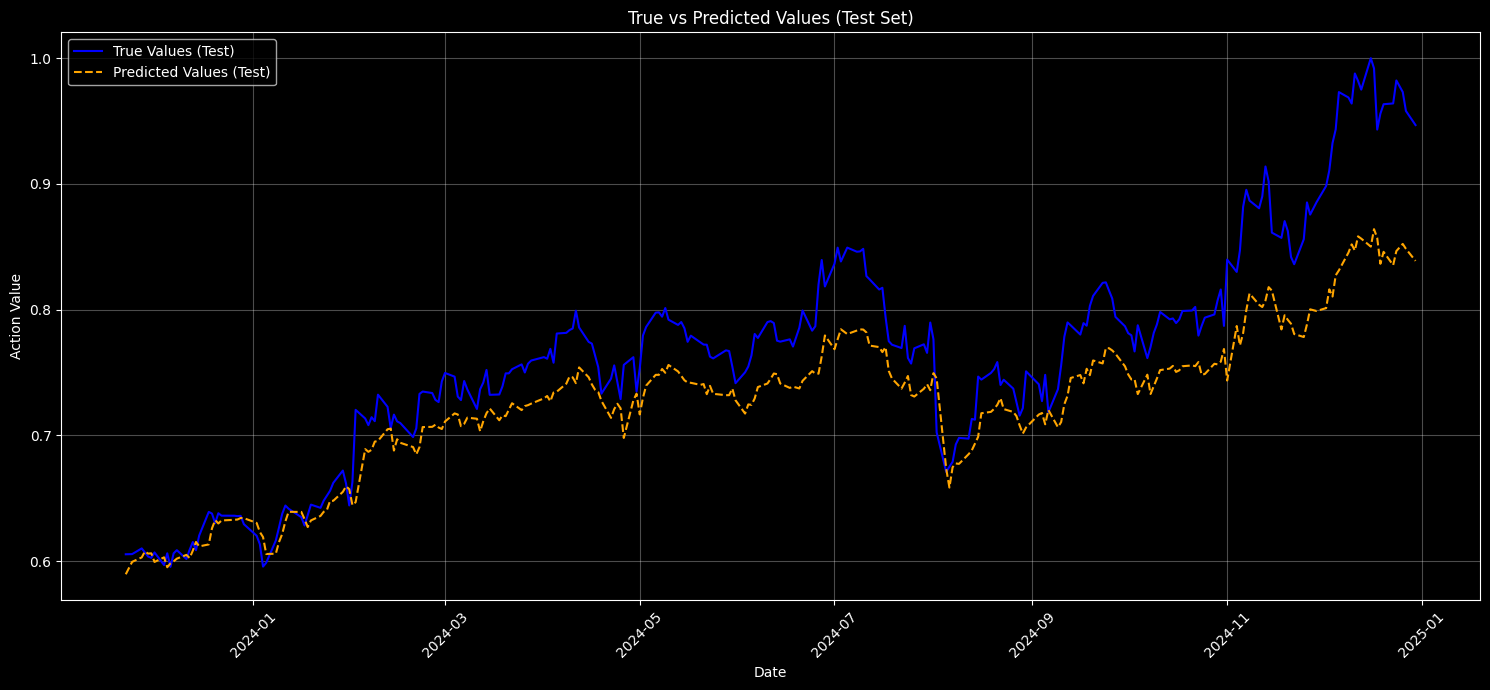

In [191]:
y_test_full = y_test
y_test_pred_full = y_test_pred
dates_test_full = merged_df["Date"].values[training_size + validation_size:]

dates_test_full_adjusted = dates_test_full[time_step:-1]

plt.figure(figsize=(15, 7))
plt.plot(dates_test_full_adjusted, y_test_full, label="True Values (Test)", color="blue", linestyle="-")
plt.plot(dates_test_full_adjusted, y_test_pred_full, label="Predicted Values (Test)", color="orange", linestyle="--")
plt.xlabel("Date")
plt.ylabel("Action Value")
plt.title("True vs Predicted Values (Test Set)")
plt.xticks(rotation=45)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()



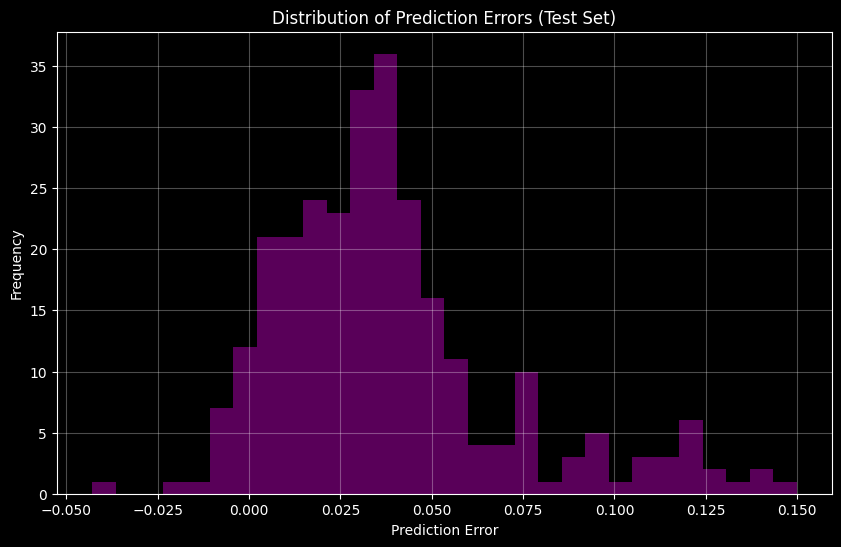

In [192]:
test_errors = y_test - y_test_pred
plt.figure(figsize=(10, 6))
plt.hist(test_errors, bins=30, color="purple", alpha=0.7)
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.title("Distribution of Prediction Errors (Test Set)")
plt.grid(alpha=0.3)
plt.show()


In [193]:
epsilon = 1e-6
errors_test = np.abs((y_test_full - y_test_pred_full) / (y_test_full + epsilon))

acceptable_margin = 0.1  # 10%

correct_predictions_test = (errors_test <= acceptable_margin).sum()

total_predictions_test = len(errors_test)
percentage_correct_test = (correct_predictions_test / total_predictions_test) * 100

print(f"Pourcentage of correct prediction : {percentage_correct_test:.2f}%")


Pourcentage of correct prediction : 90.97%


In [194]:
direction_real_test = np.sign(np.diff(y_test_full))
direction_pred_test = np.sign(np.diff(y_test_pred_full))

correct_directions_test = (direction_real_test == direction_pred_test).sum()

total_directions_test = len(direction_real_test)
direction_accuracy_test = (correct_directions_test / total_directions_test) * 100

print(f"The model correctly predicted the direction on the test set in {direction_accuracy_test:.2f}% in cases.")


The model correctly predicted the direction on the test set in 51.45% in cases.


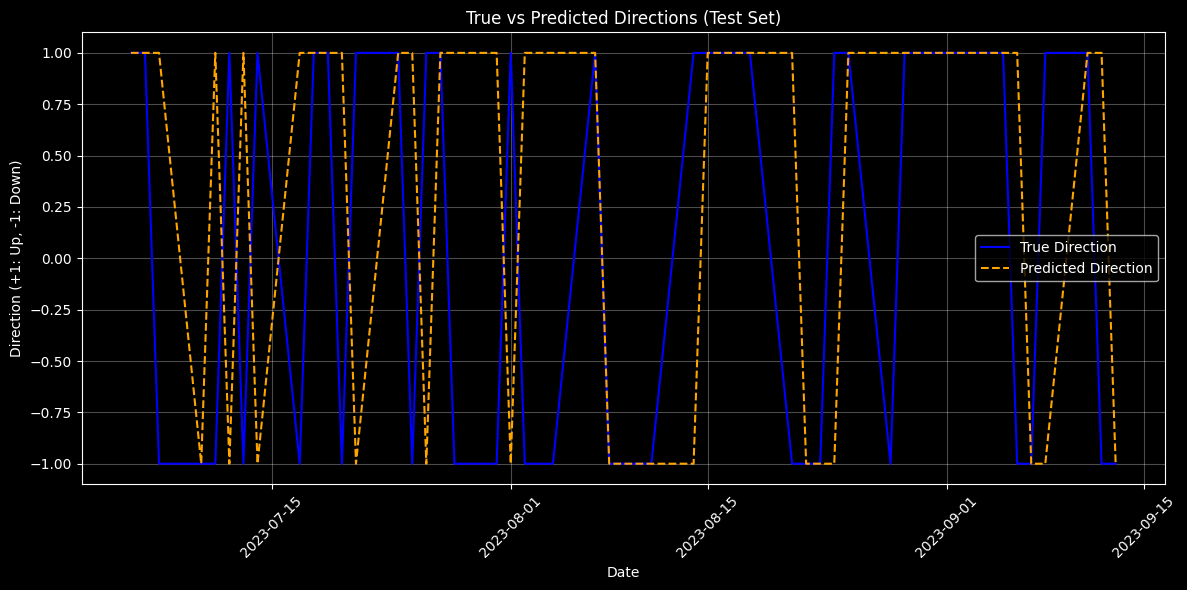

In [195]:
dates_test_diff = dates_test_full[1:]

plt.figure(figsize=(12, 6))
plt.plot(dates_test_diff[:50], direction_real_test[:50], label="True Direction", color="blue", linestyle="-")
plt.plot(dates_test_diff[:50], direction_pred_test[:50], label="Predicted Direction", color="orange", linestyle="--")
plt.xlabel("Date")
plt.ylabel("Direction (+1: Up, -1: Down)")
plt.title("True vs Predicted Directions (Test Set)")
plt.xticks(rotation=45)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [196]:
portfolio_returns = direction_pred_test * (y_test_full[1:] - y_test_full[:-1])  # Gains basés sur les prédictions
sharpe_ratio = np.mean(portfolio_returns) / np.std(portfolio_returns)
print(f"Simulated Sharpe Ratio: {sharpe_ratio:.2f}")


Simulated Sharpe Ratio: 0.06


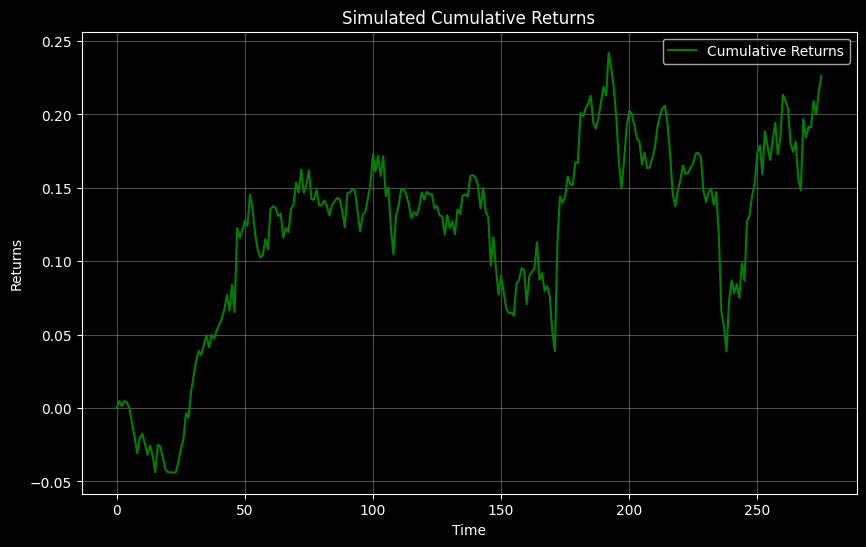

In [197]:
cumulative_returns = np.cumsum(portfolio_returns)
plt.figure(figsize=(10, 6))
plt.plot(cumulative_returns, label="Cumulative Returns", color="green")
plt.xlabel("Time")
plt.ylabel("Returns")
plt.title("Simulated Cumulative Returns")
plt.grid(alpha=0.3)
plt.legend()
plt.show()
